In [77]:
import matplotlib.pyplot as plt


def get_index(iterable):
    return random.randint(0, len(iterable) - 1)


def get_stats(tensor, p=True, r=False, minmax=False):
    if minmax:
        min, max = tensor.min(), tensor.max()
        mean, std = tensor.mean(), tensor.std()
        if p: print(f"Min: {min}, Max: {max} ,Mean: {mean}, Std: {std}")
        if r: return min, max, mean, std
    else:
        mean, std = tensor.mean(), tensor.std()
        if p: print(f"Mean: {mean}, Std: {std}")
        if r: return mean, std
        
        

def show_waves(waves, dpi=100):
    """
    waves: numpy array of shape (3, N)
    Creates three separate figures that stretch wide.
    """
    N = waves.shape[1]
    t = np.arange(N)

    # Wide aspect ratio; height modest so each window fills width
    for i in range(waves.shape[0]):
        fig = plt.figure(figsize=(14, 4), dpi=dpi)  # wide figure
        ax = fig.add_subplot(111)
        ax.plot(t, waves[i], linewidth=1)
        ax.set_title(f"Wave {i+1}")
        ax.set_xlabel("Sample")
        ax.set_ylabel("Amplitude")
        ax.grid(True)
        fig.tight_layout()  # reduce margins to use width
        
    plt.show()

In [2]:
import os

path = "/kaggle/input/dig-4-bio-raman-transfer-learning-challenge"
files = os.listdir(path)
[(i, files[i]) for i in range(len(files))]

[(0, 'sample_submission.csv'),
 (1, 'timegate.csv'),
 (2, 'mettler_toledo.csv'),
 (3, 'kaiser.csv'),
 (4, 'anton_532.csv'),
 (5, 'transfer_plate.csv'),
 (6, '96_samples.csv'),
 (7, 'tornado.csv'),
 (8, 'tec5.csv'),
 (9, 'metrohm.csv'),
 (10, 'anton_785.csv')]

In [110]:
import numpy as np
import pandas as pd


def get_dataset(name, lower, upper):
    path = "/kaggle/input/dig-4-bio-raman-transfer-learning-challenge"
    df = pd.read_csv(os.path.join(path, name))
    
    spectra_selection = np.logical_and(
        lower <= np.array([float(one) for one in df.columns[:-5]]),
        np.array([float(one) for one in df.columns[:-5]]) <= upper,
    )
    
    spectra = df.iloc[:, :-5].iloc[:, spectra_selection].values
    label = df.iloc[:, -5:-2].values

    wavenumbers = np.array([
        float(one) for one in df.columns[:-5]
    ])[spectra_selection]

    
    return spectra, label, wavenumbers


def load_datasets(ds_names, lower, upper):
    datasets = [get_dataset(name, lower, upper) for name in ds_names]
    wavenumbers = np.arange(lower, upper + 1)

    interpolated_data = [
        np.array([
            np.interp(
                wavenumbers,
                xp=wns,
                fp=spectrum,
            )
            for spectrum in spectra
        ])
        for spectra, _, wns in datasets
    ]

    normed_spectra = np.concatenate(
        [
            spectra / np.max(spectra)
            for spectra in interpolated_data
        ],
        axis=0,
    )

    labels = np.concatenate([ds[1] for ds in datasets])
    return normed_spectra, labels

ds_names = [
    "timegate.csv",
    "mettler_toledo.csv",
    "kaiser.csv",
    "anton_532.csv",
    #"transfer_plate.csv",
    "tornado.csv",
    "tec5.csv",
    "metrohm.csv",
    "anton_785.csv"
]

inputs, targets = load_datasets(ds_names, 300, 1600)
inputs.shape, targets.shape

((2261, 1301), (2261, 3))

In [111]:
import random
import torch
from torch.utils.data import Dataset
import scipy.optimize


np_dtype_from_torch = {
    torch.float32: np.float32,
    torch.float64: np.float64,
}

class SpectralDataset(Dataset):
    def __init__(
        self,
        spectra,
        concentrations,
        dtype=None,
        spectra_mean_std=None,
        concentration_mean_std=None,
        combine_spectra_range=0.0,
        baseline_factor_bound=0.0,
        baseline_period_lower_bound=100.0,
        baseline_period_upper_bound=200.0,
        augment_slope_std=0.0,
        augment_intersept_std=0.0,
        rolling_bound=0,
        spectrum_rolling_sigma=0.0,
        augmentation_weight=0.1,
        original_datapoint_weight=1.,
    ):
        self.dtype = dtype or torch.float32
        self.combine_spectra_range = combine_spectra_range
        self.baseline_factor_bound = baseline_factor_bound
        self.augment_slope_std = augment_slope_std
        self.augment_intercept_std = augment_intersept_std
        self.baseline_period_lower_bound = baseline_period_lower_bound
        self.baseline_period_upper_bound = baseline_period_upper_bound
        self.rolling_bound = rolling_bound
        self.spectrum_rolling_sigma = spectrum_rolling_sigma
        self.augmentation_weight = torch.tensor(augmentation_weight, dtype=dtype)
        self.original_dp_weight = original_datapoint_weight

        # normalize spectra
        spectra = torch.tensor(spectra, dtype=dtype)

        if spectra_mean_std is None:
            self.s_mean = torch.mean(spectra)
            self.s_std = torch.std(spectra)
        else:
            self.s_mean, self.s_std = spectra_mean_std

        self.spectra = torch.divide(
            torch.subtract(spectra, self.s_mean),
            self.s_std,
        )
        print(self.spectra.shape)
        self.dummy_wns = np.tile(
            np.arange(
                0., 1., 1. / self.spectra.shape[2],
                dtype=np_dtype_from_torch[self.dtype]
            )[None, :self.spectra.shape[2]],
            (self.spectra.shape[1], 1),
        )

        # normalize concentrations
        concentrations = torch.tensor(concentrations, dtype=dtype)
        if concentration_mean_std is None:
            self.concentration_means = torch.nanmean(concentrations, dim=0)

            self.concentration_stds = torch.maximum(
                torch.tensor(
                    [
                        torch.std(col[torch.logical_not(torch.isnan(col))])
                        for col in concentrations.T
                    ]
                ),
                torch.tensor([1e-3] * concentrations.shape[1]),
            )
        else:
            self.concentration_means = concentration_mean_std[0]
            self.concentration_stds = concentration_mean_std[1]

        self.concentrations = torch.divide(
            torch.subtract(
                concentrations,
                self.concentration_means,
            ),
            self.concentration_stds,
        )

    def pick_two(self, max_idx=None):
        max_idx = max_idx or len(self)
        return random.choices(range(max_idx), k=2)

    def __len__(self):
        return len(self.concentrations)

    def augment_spectra(self, spectra):
        if self.augment_slope_std > 0.0:

            def spectrum_approximation(x, slope, intercept):
                return (slope * x + intercept).reshape(-1, 1)[:, 0]

            slope, inter = scipy.optimize.curve_fit(
                spectrum_approximation,
                self.dummy_wns,
                spectra.reshape(-1, 1)[:, 0],
                p0=np.random.rand(2),
            )[0]

            new_slope = slope * (
                    np.random.gamma(
                        shape=1. / self.augment_slope_std,
                        scale=self.augment_slope_std,
                        size=1,
                    )
            )[0]
            new_intercept = inter * (
                1.0 + np.random.randn(1) * self.augment_intercept_std
            )[0]
            spectra += torch.tensor(
                (new_slope - slope)
            ) * self.dummy_wns + new_intercept - inter

        factor = self.baseline_factor_bound * torch.rand(size=(1,))
        offset = torch.rand(size=(1,)) * 2.0 * torch.pi
        period = self.baseline_period_lower_bound + (
            self.baseline_period_upper_bound - self.baseline_period_lower_bound
        ) * torch.rand(size=(1,))
        permutations = factor * torch.cos(
            2.0 * torch.pi / period * self.dummy_wns + offset
        )
        return self.roll_spectrum(
            spectra + permutations * spectra,
            delta=random.randint(-self.rolling_bound, self.rolling_bound),
        )

    def roll_spectrum(self, spectra, delta):
        num_spectra = spectra.shape[0]
        rolled_spectra = np.roll(spectra, delta, axis=1)
        if delta > 0:
            rolled_spectra[:, :delta] = (
                np.random.rand(num_spectra, delta) * self.spectrum_rolling_sigma + 1
            ) * rolled_spectra[:, delta:(delta + 1)]
        elif delta < 0:
            rolled_spectra[:, delta:] = (
                np.random.rand(num_spectra, -delta) * self.spectrum_rolling_sigma + 1
            ) * rolled_spectra[:, delta - 1:delta]
        return rolled_spectra

    def combine_k_items(self, indices, weights):
        return (
            # spectra
            torch.sum(
                torch.mul(weights[:, None, None], self.spectra[indices, :, :]),
                dim=0,
            ),
            # concentrations
            torch.sum(
                torch.mul(weights[:, None], self.concentrations[indices, :]),
                dim=0,
            )
        )

    def __getitem__(self, idx):
        if self.combine_spectra_range < 1e-12:
            spectrum = self.spectra[idx]
            spectrum = self.augment_spectra(spectrum)
            return {
                "spectra": spectrum,
                "concentrations": self.concentrations[idx],
                "label_weight": torch.tensor(1.0, dtype=self.dtype),
            }
        else:
            if random.random() < self.original_dp_weight:
                one_weight = 1.
                label_weight = torch.tensor(1.0, dtype=self.dtype)
            else:
                one_weight = random.uniform(0.0, self.combine_spectra_range)
                label_weight = self.augmentation_weight
            weights = torch.tensor([one_weight, (1 - one_weight)])
            # just pick two random indices
            indices = random.choices(range(len(self)), k=2)

            mixed_spectra, mixed_concentrations = self.combine_k_items(
                indices=indices,
                weights=weights,
            )
            mixed_spectra = self.augment_spectra(mixed_spectra)
            return {
                "spectra": mixed_spectra,
                "concentrations": mixed_concentrations,
                "label_weight": label_weight,
            }


In [112]:
config = {
    'initial_cnn_channels': 32,
    'cnn_channel_factor': 1.279574024454846,
    'num_cnn_layers': 8,
    'kernel_size': 3,
    'stride': 2,
    'activation_function': 'ELU',
    'fc_dropout': 0.10361700399831791,
    'lr': 0.001,
    'gamma': 0.9649606352621118,
    'baseline_factor_bound': 0.748262317340447,
    'baseline_period_lower_bound': 0.9703081695287203,
    'baseline_period_span': 19.79744237606427,
    'original_datapoint_weight': 0.4335003268130408,
    'augment_slope_std': 0.08171025264382692,
    'batch_size': 32,
    'fc_dims': 226,
    'rolling_bound': 2,
    'num_blocks': 2,
}

In [113]:
dataset = SpectralDataset(
    spectra=inputs[:, None, :],
    concentrations=targets,
    dtype=torch.float32,
    spectra_mean_std=None,
    concentration_mean_std=None,
    combine_spectra_range=1.0,
    baseline_factor_bound=config["baseline_factor_bound"],
    baseline_period_lower_bound=config["baseline_period_lower_bound"],
    baseline_period_upper_bound=(config["baseline_period_lower_bound"] + config["baseline_period_span"]),
    augment_slope_std=config["augment_slope_std"],
    augment_intersept_std=0.0,
    rolling_bound=config["rolling_bound"],
    spectrum_rolling_sigma=0.01,
    augmentation_weight=0.1,
    original_datapoint_weight=1.,
)

torch.Size([2261, 1, 1301])


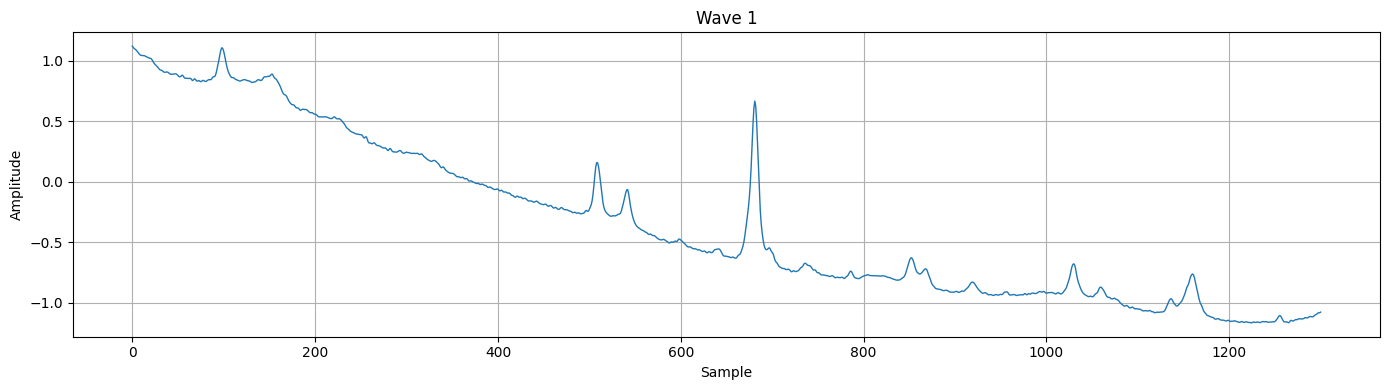

In [117]:
index = get_index(dataset)
show_waves(dataset[index]["spectra"])

In [84]:
dataset.combine_spectra_range

1.0